This is a tutorial illustrating the fitting of a linear-Gaussian GLM
(also known as linear least-squares regression model) and a Poisson GLM
(aka  "linear-nonlinear-Poisson" model) to retinal ganglion cell spike
trains stimulated with binary temporal white noise. 

DATASET: this tutorial is designed to run with retinal ganglion cell
spike train data from Uzzell & Chichilnisky 2004. The dataset can be 
downloaded here:

    http://pillowlab.princeton.edu/data/data_RGCs.zip

The dataset is provided for tutorial purposes only, and should not be
distributed or used for publication without express permission from EJ
Chichilnisky (ej@stanford.edu). 

Last updated: Mar 10, 2020 (JW Pillow)

Transfered into Python by Xiaodong LI

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import hankel,pinv
from scipy.interpolate import interp1d
from interpolation import interp
from numpy.linalg import inv,norm,lstsq
aa=np.asarray

# Load raw data

Be sure to unzip the data file data_RGCs.zip
(http://pillowlab.princeton.edu/data/data_RGCs.zip) and place it in 
this directory before running the tutorial.  
Or substitute your own dataset here instead!


(Data from Uzzell & Chichilnisky 2004):

In [3]:
datadir='../data_RGCs/' # directory where stimulus lives
Stim=loadmat(datadir+'Stim.mat')['Stim'].flatten() # stimulus (temporal binary white noise)
stimtimes=loadmat(datadir+'stimtimes.mat')['stimtimes'].flatten() # stim frame times in seconds (if desired)
SpTimes=loadmat(datadir+'SpTimes.mat')['SpTimes'][0,:] # load spike times (in units of stim frames)
SpTimes=[p.flatten() for p in SpTimes] # flatten every column vector into one-dimensional array

In [4]:
Stim

array([-0.48,  0.48,  0.48, ...,  0.48,  0.48,  0.48])

In [5]:
Stim.shape

(144051,)

In [6]:
stimtimes

array([8.34060500e-03, 1.66812100e-02, 2.50218150e-02, ...,
       1.20145581e+03, 1.20146415e+03, 1.20147249e+03])

In [7]:
stimtimes.shape

(144051,)

In [19]:
np.diff(stimtimes)

array([0.0083406 , 0.0083406 , 0.00834061, ..., 0.0083406 , 0.00834061,
       0.00834061])

Pick a cell to work with

In [8]:
cellnum=2 #(0-1 are OFF cells; 2-3 are ON cells).
tsp=SpTimes[cellnum]
tsp

array([4.89593950e-02, 5.22593950e-02, 5.73093950e-02, ...,
       1.20138237e+03, 1.20138662e+03, 1.20139027e+03])

In [9]:
tsp.shape

(49954,)

Compute some basic statistics on the data

In [10]:
dtStim=stimtimes[1]-stimtimes[0] # time bin size for stimulus(s)
RefreshRate=1/dtStim # Refresh rate of the monitor
nT=Stim.shape[0] # stim frame times in seconds (if desired)
nsp=tsp.shape[0] # load spike times (in units of stim frames)

Print out some basic info

In [11]:
print('--------------------------')
print('Loaded RGC data: cell %d\n'%cellnum)
print('Number of stim frames: %d  (%.1f minutes)\n'%(nT, nT*dtStim/60))
print('Time bin size: %.1f ms\n'%(dtStim*1000))
print('Number of spikes: %d (mean rate=%.1f Hz)\n\n'%(nsp, nsp/nT*RefreshRate))

--------------------------
Loaded RGC data: cell 2

Number of stim frames: 144051  (20.0 minutes)

Time bin size: 8.3 ms

Number of spikes: 49954 (mean rate=41.6 Hz)




Let's visualize some of the raw data

Text(0.5, 0, 'time (s)')

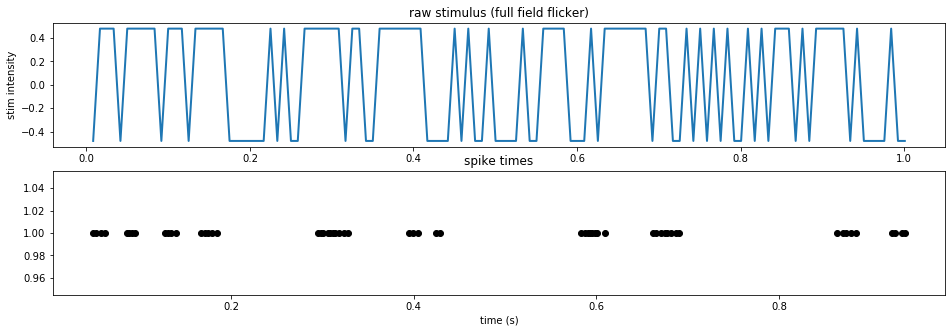

In [12]:
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(16,5))
iiplot=np.arange(0,120,1) # bins of stimulus to plot
ttplot=(iiplot+1)*dtStim # time bins of stimulus
axes[0].plot(ttplot,Stim[iiplot],linewidth=2.0)
axes[0].set_title('raw stimulus (full field flicker)')
axes[0].set_ylabel('stim intensity')

tspplot=tsp[(tsp>=ttplot[0])&(tsp<ttplot[-1])]
axes[1].plot(tspplot,np.ones_like(tspplot),'ko',markerfacecolor='k')
axes[1].set_xlim=[ttplot[0],ttplot[-1]]
axes[1].set_title('spike times')
axes[1].set_xlabel('time (s)')

what is the probabilistic relationship between stimuli and spike trains?

<img src='pics/f1-1.png'>

<img src='pics/f1-2.png'>

# Bin the spike train

For now we will assume we want to use the ___same time___ bin size as the time
bins used for the stimulus. Later, though, we'll wish to vary this.

In [13]:
tbins=np.arange(.5,nT+1.5)*dtStim # time bin centers for spike train binning
sps,tbins=np.histogram(tsp,bins=nT,range=(tbins.min(),tbins.max())) # binned spike train

Replot the responses we'll putting into our regression as counts

<ipython-input-14-160e5ecbcf23>:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes.stem(ttplot,sps[iiplot])


(0, 3.5)

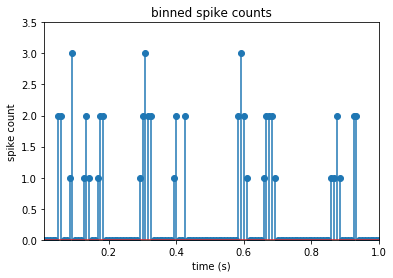

In [14]:
fig,axes=plt.subplots()
axes.stem(ttplot,sps[iiplot])
axes.set_title("binned spike counts")
axes.set_ylabel("spike count")
axes.set_xlabel("time (s)")
axes.set_xlim((ttplot[0],ttplot[-1]))
axes.set_ylim((0,3.5))

# Build the design matrix: slow version

This is a necessary step before we can fit the model: assemble a matrix that contains the relevant regressors for each time bin of the response, known as a design matrix.  Each row of this matrix contains the relevant stimulus chunk for predicting the spike count at a given time bin

Set __the number of time bins of stimulus__ to use for predicting spikes

In [22]:
ntfilt=25 # Try varying this, to see how performance changes!

## Build the design matrix: Slow version

In [23]:
paddedStim=np.r_[np.zeros(ntfilt-1),Stim] # pad early bins of stimulus with zero
Xdsgn=np.zeros([nT,ntfilt])
for j in range(nT):
    Xdsgn[j,:]=paddedStim[j:j+ntfilt] # grab last 'nkt' bins of stmiulus and insert into this row

Let's visualize a small part of the design matrix just to see it

Text(0.5, 1.0, 'Design matrix')

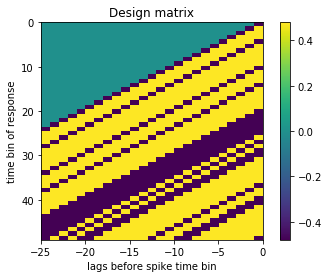

In [24]:
fig,axes=plt.subplots()
im=axes.imshow(Xdsgn[:50,:],extent=[-ntfilt,0,49,0],aspect=0.5)
fig.colorbar(im)
axes.set_xlabel('lags before spike time bin')
axes.set_ylabel('time bin of response')
axes.set_title('Design matrix')

Notice it has a structure where every row is a shifted copy of the row
above, which comes from the fact that for each time bin of response,
we're grabbing the preceding 'nkt' bins of stimulus as predictor

## Build the design matrix: fast version

Of course there's a faster / more elegant way to do this. The design
matrix here is known as a 'Hankel' matrix, which is the same as a
Toeplitz matrix flipped left to right. A Hankel matrix is entirely
determined by its first column and bottom row.  (Type 'help hankel', to
learn more about this function).

Build design matrix without using a for loop

In [25]:
paddedStim=np.r_[np.zeros(ntfilt-1),Stim] # pad early bins of stimulus with zero
Xdsgn=hankel(paddedStim[:-ntfilt+1],Stim[-ntfilt:])

In [26]:
paddedStim[:-ntfilt+1].shape

(144051,)

In [27]:
Stim[-ntfilt:].shape

(25,)

In [29]:
Xdsgn.shape

(144051, 25)

#### Note `hankel`

a [Hankel matrix](https://en.wikipedia.org/wiki/Hankel_matrix) is any $n\times n$ matrix $A$ of the form

$$
A = \begin{bmatrix}a_{0}&a_{1}&a_{2}&\ldots &\ldots &a_{n-1}\\a_{1}&a_{2}&&&&\vdots \\a_{2}&&&&&\vdots \\\vdots &&&&&a_{2n-4}\\\vdots &&&&a_{2n-4}&a_{2n-3}\\a_{n-1}&\ldots &\ldots &a_{2n-4}&a_{2n-3}&a_{2n-2}\end{bmatrix}
$$

In terms of the components, if the $i$,$j$ element of $A$ is denoted with $A_{ij}$, and assuming $i\leq j$ , then we have $A_{i,j}=A_{i+k,j−k}$ for all $k = 0 , . . . , j − i$.


In numpy or MATLAB,
```python
>>> hankel([1,2,3,4], [5,7,7,8,9])
>>> array([[1, 2, 3, 4, 7],
       [2, 3, 4, 7, 7],
       [3, 4, 7, 7, 8],
       [4, 7, 7, 8, 9]])
>>> hankel([1,2,3,4,5],[4,7,8,9])
>>> array([[1, 2, 3, 4],
       [2, 3, 4, 5],
       [3, 4, 5, 7],
       [4, 5, 7, 8],
       [5, 7, 8, 9]])
```

(You can check for you like that this gives the same matrix as the one created above!)

Text(0.5, 1.0, 'Design matrix')

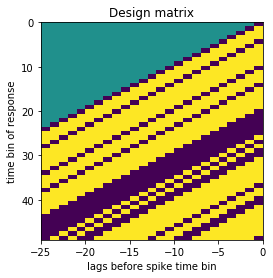

In [121]:
fig,axes=plt.subplots()
axes.imshow(Xdsgn[:50,:],extent=[-ntfilt,0,49,0],aspect=0.5)
axes.set_xlabel('lags before spike time bin')
axes.set_ylabel('time bin of response')
axes.set_title('Design matrix')

<img src='pics/f1-6.png'>

# Compute and visualize the spike-triggered average (STA)

When the stimulus is Gaussian white noise, the __STA__ provides an unbiased
estimator for the filter in a GLM / [LNP](https://en.wikipedia.org/wiki/Linear-nonlinear-Poisson_cascade_model) model (as long as the nonlinearity
results in an STA whose expectation is not zero; feel free 
to ignore this parenthetical remark if you're not interested in technical
details. It just means that if the nonlinearity is symmetric, 
eg. x^2, then this condition won't hold, and the STA won't be useful).

In many cases it's useful to visualize the STA (even if your stimuli are
not white noise), just because if we don't see any kind of structure then
this may indicate that we have a problem (e.g., a mismatch between the
design matrix and binned spike counts.


__Note__: STA gives a relationship between stimulus and spike

It's extremely easy to compute the STA now that we have the design matrix

In [32]:
sta = (Xdsgn.T@sps)/nsp # (design matrix * spike counts)/number of spikes

Plot it

Text(0.5, 0, 'time before spike(s)')

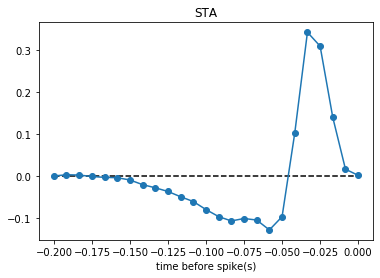

In [33]:
ttk=np.arange(-ntfilt+1,1)*dtStim
fig,axes=plt.subplots() # time bins for STA (in seconds)
axes.plot(ttk,ttk*0,'k--')
axes.plot(ttk,sta,'o-')
axes.set_title('STA')
axes.set_xlabel('time before spike(s)')

If you're still using cell #0, this should look like a biphasic filter
with a negative lobe just prior to the spike time.

(By contrast, if this looks like garbage then it's a good chance we did
something wrong!)

## whitened STA (ML(Maximum Likelihood) fit to filter for linear-Gaussian GLM)

If the stimuli are ___non-white___, then the STA is generally a biased
estimator for the linear filter. In this case we may wish to compute the
__"whitened" STA__, which is also the maximum-likelihood estimator for the filter of a 
GLM with "identity" nonlinearity and Gaussian noise (also known as
least-squares regression). 

If the stimuli have ___correlations___ this ML estimate may look like garbage
(more on this later when we come to "__regularization__").  But for this
dataset the stimuli are white, so we don't (in general) expect a big
difference from the STA.  (This is because the whitening matrix
`inv(Xdsgn.T@Xdsgn)` is close to a scaled version of the identity.


__Note__: wSTA gives a relationship between stimulus and spike using linear regression

whitened STA

In [36]:
wsta = lstsq(Xdsgn.T@Xdsgn,sta)[0]*nsp

<ipython-input-36-e46d125e473e>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wsta = lstsq(Xdsgn.T@Xdsgn,sta)[0]*nsp


or equivalently `inv(Xdsgn.T@Xdsgn)@(Xdsgn.T@sps)`
this is just the least-squares regression formula!

Let's plot them both (rescaled as unit vectors so we can see differences
in their shape).

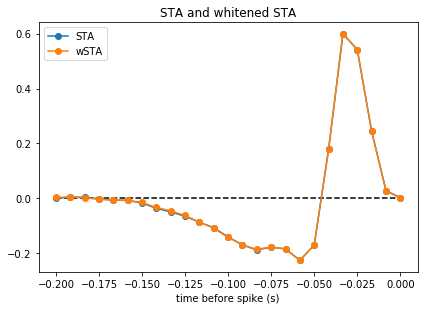

In [37]:
fig,axes=plt.subplots()
axes.plot(ttk,ttk*0,'k--')
axes.plot(ttk,sta/norm(sta),'o-',label='STA')
axes.plot(ttk,wsta/norm(wsta),'o-',label='wSTA')
fig.tight_layout()
axes.set_title('STA and whitened STA')
axes.set_xlabel('time before spike (s)')
axes.legend()

# Predicting spikes with a linear-Gaussian GLM

The whitened STA can actually be used to predict spikes because it
corresponds to a proper estimate of the model parameters (i.e., for a
Gaussian GLM). Let's inspect this prediction

Note: this is an in-sample prediction

In [38]:
sppred_lgGLM = Xdsgn@wsta  # predicted spikes from linear-Gaussian GLM

Let's see how good this "prediction" is
(Prediction in quotes because we are (for now) looking at the performance
on training data, not test data... so it isn't really a prediction!)

Plot real spike train and prediction

<ipython-input-39-6845d6e8d912>:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes.stem(ttplot,sps[iiplot],label='spike count')


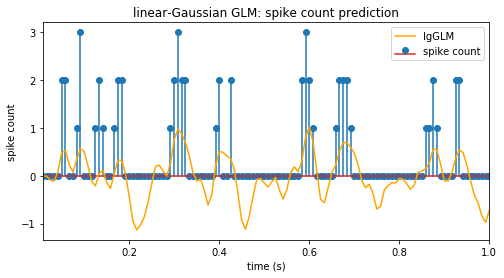

In [39]:
fig,axes=plt.subplots(figsize=(8,4))

axes.stem(ttplot,sps[iiplot],label='spike count')
axes.plot(ttplot,sppred_lgGLM[iiplot],color='orange',label='lgGLM')

axes.set_title('linear-Gaussian GLM: spike count prediction')
axes.set_ylabel('spike count')
axes.set_xlabel('time (s)')
axes.set_xlim(ttplot[0],ttplot[-1])
axes.legend()

# Fitting and predicting with a linear-Gaussian-GLM with offset

Oops, one thing we forgot above was to include an offset or "constant"
term in the design matrix, which will allow our prediction to have
non-zero mean (since the stimulus here was normalized to have zero mean).

Updated design matrix

__Note__: a constant is added into design matrix

In [40]:
Xdsgn2 = np.c_[np.ones((nT,1)), Xdsgn] # just add a column of ones

Compute whitened STA

In [42]:
MLwts = lstsq(Xdsgn2.T@Xdsgn2,Xdsgn2.T@sps)[0] # this is just the LS regression formula
const = MLwts[0] # the additive constant
wsta2 = MLwts[1:] # the linear filter part

<ipython-input-42-ec532fc3d1b4>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  MLwts = lstsq(Xdsgn2.T@Xdsgn2,Xdsgn2.T@sps)[0] # this is just the LS regression formula（linear regression）


Now redo prediction (with offset)

In [43]:
sppred_lgGLM2 = const + Xdsgn@wsta2

Plot this stuff

<ipython-input-44-7ca96c50fc5d>:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes.stem(ttplot,sps[iiplot],label='spike count')


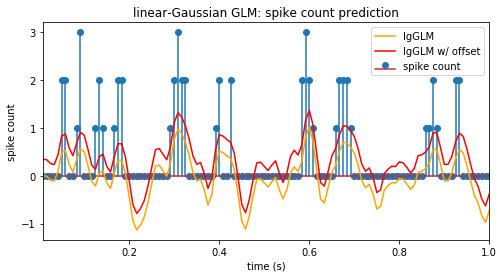

In [44]:
fig,axes=plt.subplots(figsize=(8,4))
axes.stem(ttplot,sps[iiplot],label='spike count')
axes.plot(ttplot,sppred_lgGLM[iiplot],color='orange',label='lgGLM')
axes.plot(ttplot,sppred_lgGLM2[iiplot],color='red',label='lgGLM w/ offset')

axes.set_title('linear-Gaussian GLM: spike count prediction')
axes.set_ylabel('spike count')
axes.set_xlabel('time (s)')
axes.set_xlim(ttplot[0],ttplot[-1])
axes.legend()

Let's report the relevant training error (squared prediction error on training data) 
so far just to see how we're doing:

In [45]:
mse1 = np.mean((sps-sppred_lgGLM)**2) # mean squared error, GLM no offset
mse2 = np.mean((sps-sppred_lgGLM2)**2) # mean squared error, with offset
rss = np.mean((sps-np.mean(sps))**2) # squared error of spike train
print('Training perf (R^2): lin-gauss GLM, no offset: %.2f\n'%(1-mse1/rss))
print('Training perf (R^2): lin-gauss GLM, w/ offset: %.2f\n'%(1-mse2/rss))

Training perf (R^2): lin-gauss GLM, no offset: 0.12

Training perf (R^2): lin-gauss GLM, w/ offset: 0.39



# Poisson GLM

<img src='pics/f1-4.png'>

<img src='pics/f1-5.png'>

Let's finally move on to the LNP / [Poisson GLM](https://en.wikipedia.org/wiki/Poisson_regression)!

This is super-easy if we rely on built-in GLM fitting code

In [56]:
import statsmodels.api as sm
# the default link function of GLM is Gaussain
glmModel=sm.GLM(sps,sm.add_constant(Xdsgn),
                family=sm.families.Poisson(),
                link=sm.families.links.Log).fit() # the default link of Poisson family is log

pGLMwts=glmModel.params
pGLMconst=pGLMwts[0] # constant ("dc term")
pGLMfilt=pGLMwts[1:] # stimulus filter

The `sm.GLM` function will fit a GLM for us. Here we have specified that
we want the noise model to be Poisson. The default setting for the link
function (the inverse of the nonlinearity) is `np.log`, so default
nonlinearity is `np.exp`). The last argument tells glmfit to include a
constant offset parameter in the model, so we can use the `Xdsgn` matrix
instead of the `Xdsgn2` matrix that contains 1's in the first row.

Compute predicted spike rate on training data

In [57]:
ratepred_pGLM = np.exp(pGLMconst + Xdsgn@pGLMfilt)

## Make plots showing and spike rate predictions

<ipython-input-58-f454e9495948>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes[1].stem(ttplot,sps[iiplot],label='spike count')


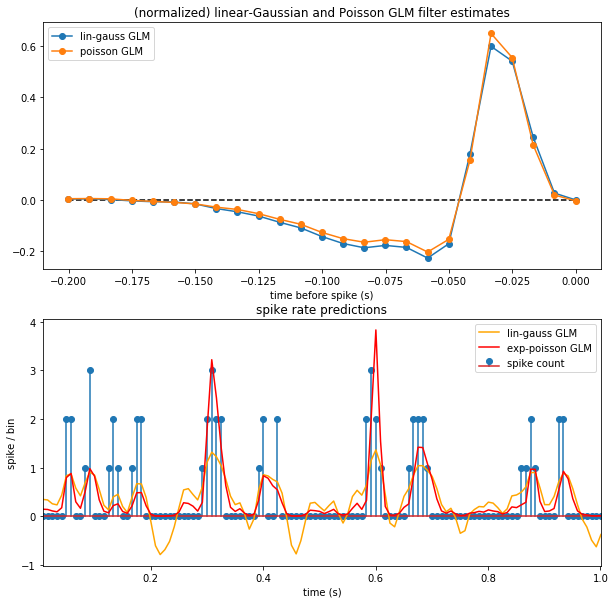

In [58]:
fig,axes=plt.subplots(nrows=2,figsize=(10,10))
axes[0].plot(ttk,ttk*0,'k--')
axes[0].plot(ttk,wsta2/norm(wsta2),'o-',label='lin-gauss GLM')
axes[0].plot(ttk,pGLMfilt/norm(pGLMfilt),'o-',label='poisson GLM')
axes[0].set_title('(normalized) linear-Gaussian and Poisson GLM filter estimates')
axes[0].set_xlabel('time before spike (s)')
axes[0].legend()

axes[1].stem(ttplot,sps[iiplot],label='spike count')
axes[1].plot(ttplot,sppred_lgGLM2[iiplot],color='orange',label='lin-gauss GLM')
axes[1].plot(ttplot,ratepred_pGLM[iiplot],color='red',label='exp-poisson GLM')
axes[1].set_title('spike rate predictions')
axes[1].set_ylabel('spike / bin')
axes[1].set_xlabel('time (s)')
axes[1].set_xlim(ttplot[0],ttplot[-1])
axes[1].legend()

Note the rate prediction here is in units of spikes/bin. If we wanted
spikes/sec, we could divide it by bin size dtStim.

__Note__

1.lin-gaussian GLM means that the `f` is linear and the `y` is gaussian

2.exp-poisson GLM means that the `f` is exponential and the `y` is poisson

# Non-parametric estimate of the nonlinearity

The above fitting code assumes a GLM with an exponential nonlinearity
(i.e., governing the mapping from filter output to instantaneous spike
rate). We might wish to examine the adequacy of that assumption and make
a "nonparametric" estimate of the nonlinearity using a more flexible
class of functions.

Let's use the family of piece-wise constant functions, which results in a
very simple estimation procedure:

1. Bin the filter outputs
2. In each bin, compute the fraction of stimuli elicted spikes

number of bins for parametrizing the nonlinearity f. (Try varying this!) 

In [59]:
nfbins = 25

compute filtered stimulus

In [60]:
rawfilteroutput = pGLMconst + Xdsgn@pGLMfilt

bin filter output and get bin index for each filtered stimulus

In [61]:
cts,binedges=np.histogram(rawfilteroutput,bins=nfbins)
binID=np.digitize(rawfilteroutput,bins=binedges)
fx=binedges[:-1]+(binedges[1]-binedges[0])/2 # use bin centers for x positions

now compute mean spike count in each bin

In [107]:
fy=np.zeros(nfbins) # y values for nonlinearity
for jj in range(nfbins):
    fy[jj]=np.mean(sps[binID==jj])
fy/=dtStim # divide by bin size to get units of sp/s
fy=np.nan_to_num(fy) # in case some of bins have no value

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Now let's embed this in a function we can evaluate at any point

In [108]:
fnlin=interp1d(fx,fy,kind='nearest',fill_value='extrapolate')

Make plots

Text(0.5, 1.0, 'nonlinearity')

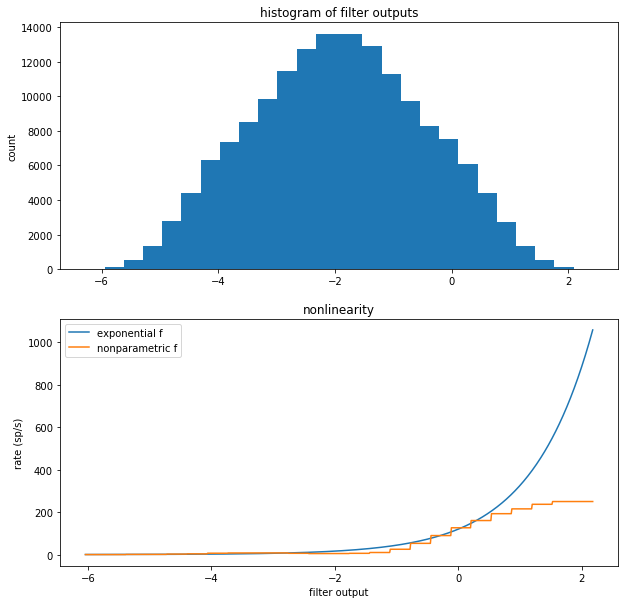

In [109]:
fig,axes=plt.subplots(nrows=2,figsize=(10,10))

axes[0].bar(fx,cts) # Plot exponential and nonparametric nonlinearity estimate
axes[0].set_ylabel('count')
axes[0].set_title('histogram of filter outputs')

xx=np.arange(binedges[0],binedges[-1],.01)
axes[1].plot(xx,np.exp(xx)/dtStim)
axes[1].plot(xx,fnlin(xx))
axes[1].set_xlabel('filter output')
axes[1].set_ylabel('rate (sp/s)')
axes[1].legend(['exponential f', 'nonparametric f'])
axes[1].set_title('nonlinearity')

What do you think of the exponential fit? Does this look like a good
approximation to the nonparametric estimate of the nonlinearity?  Can you
propose a better parametric nonlinearity to use instead?  

Advanced exercise: write your own log-likelihood function that allows you 
to jointly optimize log-likelihood for the filter parameters and
nonlinearity.  (By contrast, here we have optimized filter params under
exponential nonlinearity and THEN fit the nonlinearity using these fixed
filter parameters).  We could, for example, iteratively climb the
log-likelihood as a function of filter params and nonlinearity params;
this is a method known as "coordinate ascent").

# Quantifying performance: log-likelihood

Lastly, compute log-likelihood for the Poisson GLMs we've used so far and
compare performance.

LOG-LIKELIHOOD (this is what GLM maximizes when fitting the GLM):

--------------

Let s be the spike count in a bin and r is the predicted spike rate
(known as "conditional intensity") in units of spikes/bin, then we have:   

        Poisson likelihood:      P(s|r) = r^s/s! exp(-r)  
     giving log-likelihood:  log P(s|r) =  s log r - r   

(where we have ignored the -log s! term because it is independent of the
parameters). The total log-likelihood is the summed log-likelihood over
time bins in the experiment.

For deduction, see [GLM Poisson model logliklihood](https://en.wikipedia.org/wiki/Poisson_regression#:~:text=A%20Poisson%20regression%20model%20is%20sometimes%20known%20as,to%20the%20mean%20made%20by%20the%20Poisson%20model.)

1. for GLM with exponential nonlinearity

In [110]:
ratepred_pGLM=np.exp(pGLMconst+Xdsgn@pGLMfilt) # rate under exp nonlinearity # exp(r) symbol above
LL_expGLM=sps.T@np.log(ratepred_pGLM)-np.sum(ratepred_pGLM) # log P(s|r) above

2. for GLM with non-parametric nonlinearity

In [113]:
ratepred_pGLMnp=dtStim*fnlin(pGLMconst+Xdsgn@pGLMfilt) # rate under interpolated nonlinearity
LL_npGLM=sps[sps>0].T@np.log(ratepred_pGLM[sps>0])-np.sum(ratepred_pGLMnp) 

Now compute the rate under "homogeneous" Poisson model that assumes a
constant firing rate with the correct mean spike count.

In [114]:
ratepred_const = nsp/nT # mean number of spikes / bin
LL0 = nsp*np.log(ratepred_const) - nT*ratepred_const

Single-spike information:

------------------------

The difference of the loglikelihood and homogeneous-Poisson
loglikelihood, normalized by the number of spikes, gives us an intuitive
way to compare log-likelihoods in units of bits / spike.  This is a
quantity known as the (empirical) single-spike information.
[See Brenner et al, "Synergy in a Neural Code", Neural Comp 2000].
You can think of this as the number of bits (number of yes/no questions
that we can answer) about the times of spikes when we know the spike rate
output by the model, compared to when we only know the (constant) mean
spike rate. 

In [115]:
SSinfo_expGLM=(LL_expGLM-LL0)/nsp/np.log(2)
SSinfo_npGLM=(LL_npGLM-LL0)/nsp/np.log(2)
# (if we don't divide by log 2 we get it in nats)

In [116]:
print('\n empirical single-spike information:\n ---------------------- \n')
print('exp-GLM: %.2f bits/sp'%SSinfo_expGLM)
print(' np-GLM: %.2f bits/sp'%SSinfo_npGLM)


 empirical single-spike information:
 ---------------------- 

exp-GLM: 1.09 bits/sp
 np-GLM: 1.46 bits/sp


Let's plot the rate predictions for the two models 

--------------------------------------------------

<ipython-input-117-d17792efa852>:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes.stem(ttplot,sps[iiplot])


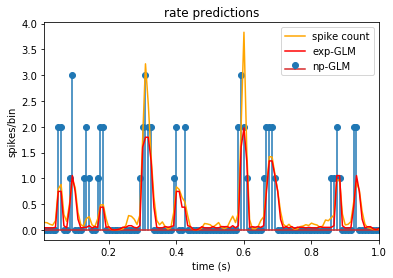

In [117]:
fig,axes=plt.subplots()
axes.stem(ttplot,sps[iiplot])
axes.plot(ttplot,ratepred_pGLM[iiplot],color='orange')
axes.plot(ttplot,ratepred_pGLMnp[iiplot],color='red')
axes.set_title('rate predictions')
axes.set_ylabel('spikes/bin')
axes.set_xlabel('time (s)')
axes.set_xlim(ttplot[0],ttplot[-1])
axes.legend(['spike count', 'exp-GLM', 'np-GLM'])

# Quantifying performance: AIC

Akaike information criterion (AIC) is a method for model comparison that
uses the maximum likelihood, penalized by the number of parameters.
(This allows us to compensate for the fact that models with more
parameters can in general achieve higher log-likelihood. AIC determines
how big this tradeoff should be in terms of the quantity:
       
       AIC = - 2*log-likelihood + 2 * number-of-parameters

The model with lower AIC is 
their likelihood (at the ML estimate), penalized by the number of parameters

In [86]:
AIC_expGLM = -2*LL_expGLM + 2*(1+ntfilt)
AIC_npGLM = -2*LL_npGLM + 2*(1+ntfilt+nfbins)

print('\n AIC comparison:\n ---------------------- \n')
print('exp-GLM: %.1f\n'%AIC_expGLM)
print(' np-GLM: %.1f\n'%AIC_npGLM)
print('\nAIC diff (exp-np)= %.2f\n'%(AIC_expGLM-AIC_npGLM))
if AIC_expGLM < AIC_npGLM:
    print('AIC supports exponential-nonlinearity!\n')
else:
    print('AIC supports nonparametric nonlinearity!\n')
    # (despite its greater number of parameters)



 AIC comparison:
 ---------------------- 

exp-GLM: 130054.9

 np-GLM: 104542.3


AIC diff (exp-np)= 25512.66

AIC supports nonparametric nonlinearity!



Caveat: technically the AIC should be using the maximum of the likelihood
for a given model.  Here we actually have an underestimate of the
log-likelihood for the non-parameteric nonlinearity GLM because
because we left the filter parameters unchanged from the exponential-GLM.
So a proper AIC comparison (i.e., if we'd achieved a true ML fit) would
favor the non-parametric nonlinearity GLM even more!

Exercise: go back and increase 'nfbins', the number of parameters (bins)
governing the nonparametric nonlinearity. If you increase it enough, you
should be able to flip the outcome so exponential nonlinearity wins.

(Note: in the third tutorial we'll use cross-validation to properly
evaluate the goodness of the fit of the models, e.g., allowing us to
decide how many bins of stimulus history or how many bins to use for the
non-parametric nonlinearity, or how to set regularization
hyperparameters. The basic idea is to split data into training and test
sets.  Fit the parameters on the training set, and compare models by
evaluating log-likelihood on test set.)

# Simulating the GLM / making a raster plot

Lastly, let's simulate the response of the GLM to a repeated stimulus and
make [__raster plots__](https://en.wikipedia.org/wiki/Temporal_Raster_Plot)

In [118]:
iiplot = np.arange(60) # time bins of stimulus to use
ttplot = iiplot*dtStim # time indices for these stimuli
StimRpt = Stim[iiplot] # repeat stimulus 
nrpts = 50 # number of repeats
frate = np.exp(pGLMconst+Xdsgn[iiplot,:]@pGLMfilt) # firing rate in each bin

Or uncomment this line to use the non-parametric nonlinearity instead:
```python
    frate = dtStim*fnlin(pGLMconst+Xdsgn[iiplot,:]@pGLMfilt) # firing rate in each bin
```
First, plot stimulus and true spikes

Text(0.5, 1.0, 'true spike times')

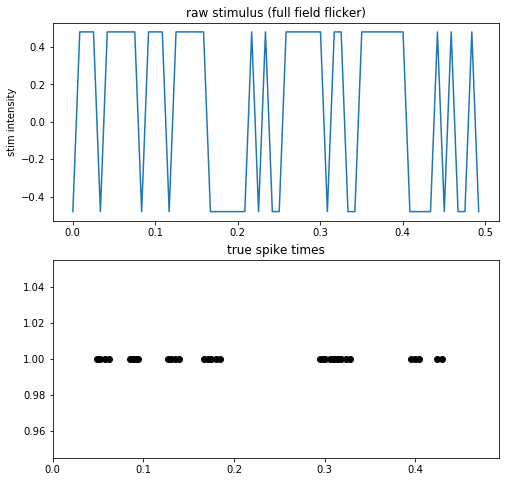

In [119]:
fig,axes=plt.subplots(nrows=2,figsize=(8,8))
axes[0].plot(ttplot,Stim[iiplot])
axes[0].set_title('raw stimulus (full field flicker)')
axes[0].set_ylabel('stim intensity')

tspplot=tsp[(tsp>=ttplot[0])&(tsp<ttplot[-1])]
axes[1].plot(tspplot,np.ones_like(tspplot),'ko')
axes[1].set_xlim(ttplot[0],ttplot[-1])
axes[1].set_title('true spike times')

Simulate spikes using draws from a Bernoulli (coin flipping) process

Text(0.5, 1.0, 'GLM spike trains')

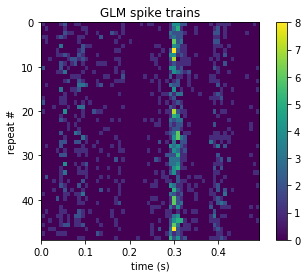

In [120]:
spcounts=aa([np.random.poisson(f,size=nrpts) for f in frate]).T # sample spike counts for each time bin
fig,axes=plt.subplots()
im=axes.imshow(spcounts,extent=[ttplot[0],ttplot[-1],nrpts-1,0],aspect=0.01)
fig.colorbar(im)
axes.set_ylabel('repeat #')
axes.set_xlabel('time (s)')
axes.set_title('GLM spike trains')

Optional: redo using ___finer time bins___, so we get maximum 1 spike per bin

In [121]:
upsampfactor = 100 # divide each time bin by this factor
dt_fine = dtStim/upsampfactor # use bins 100 time bins finer
tt_fine = np.arange(dt_fine/2,ttplot[-1],dt_fine)

Compute the fine-time-bin firing rate (which must be scaled down by bin width)

In [122]:
frate_fine=interp1d(ttplot,frate,kind='nearest',fill_value='extrapolate')(tt_fine).T/upsampfactor

now draw fine-timescale spike train

In [123]:
spcounts_fine=aa([np.random.poisson(f,size=nrpts) for f in frate_fine]).T # sample spike counts for each time bin

Make plot

Text(0.5, 1.0, 'GLM spike trains')

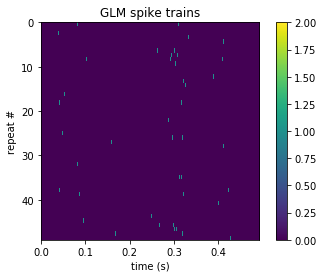

In [124]:
fig,axes=plt.subplots()
im=axes.imshow(spcounts_fine,extent=[ttplot[0],ttplot[-1],nrpts-1,0],aspect=0.01)
fig.colorbar(im)
axes.set_ylabel('repeat #')
axes.set_xlabel('time (s)')
axes.set_title('GLM spike trains')

Suggested Exercises (advanced)
-------------------------------

1) Go back and try it out for the other three neurons!
(Go to block 1 and change the variable 'cellnum' to 1, 2, or 3.)
 
2) Write your own code to do maximum likelihood estimation of the filter
and the nonlinearity.  Your function should take in the parameters for
the filter and the nonlinearity, and compute the Poisson log-likelihood
function, the log Probability of the spike responses given the stimuli
and the parameters.  A nice way to parametrize the nonlinearity is with a
linear combination of basis functions, e.g.

      f(x) = sum_i  w_i * f_i(x)

where f_i(x) is the i'th basis function and w_i is the weight on that
basis function.  You can choose the f_i to be Gaussian bumps or sigmoids,
i.e. f_i(x) = 1./(1+exp(-x - c_i)) where c_i is the shift for the i'th
basis function.

Another alternative (that will prevent negative firing rates) is to
parameterize the log-firing rate with a linear combination of basis
functions, e.g.

      log(f(x)) = sum_i  w_i * f_i(x)

meaning that
      
      f(x) = exp(sum_i  w_i * f_i(x))

Now your weights can be negative or positive without fear of generating
negative values (which will cause your negative log-likelihood function
to give nans or -infs.  
 
Write a function that takes in k and weight vector w and computes the
Poisson log-likelihood.  Hand that function off to fminunc and compare
the accuracy of the fits you get to the model with fixed exponential
nonlinearity.